Training LSTM model on 1500 seeds...
Epoch 1/100
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 100s 23ms/step - loss: 0.3712 - val_loss: 0.3350 - learning_rate: 0.0010
Epoch 2/100
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 86s 22ms/step - loss: 0.3176 - val_loss: 0.3309 - learning_rate: 0.0010
Epoch 3/100
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 80s 21ms/step - loss: 0.3108 - val_loss: 0.3587 - learning_rate: 0.0010
Epoch 4/100
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 85s 22ms/step - loss: 0.3075 - val_loss: 0.3486 - learning_rate: 0.0010
Epoch 5/100
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 85s 22ms/step - loss: 0.3065 - val_loss: 0.3387 - learning_rate: 0.0010
Epoch 6/100
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - loss: 0.3034 - val_loss: 0.3871 - learning_rate: 0.0010
Epoch 7/100
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 84s 22ms/step - loss: 0.3016 - val_loss: 0.3250 - learning_rate: 0.0010
Epoch 8/100
3836/3836 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - loss: 0.3020 - val_loss: 0.3332 - learning_rate: 0.0010
Epoch 9/100
3836/3836 ━━━━━━━━━━━━━━━━━━━━

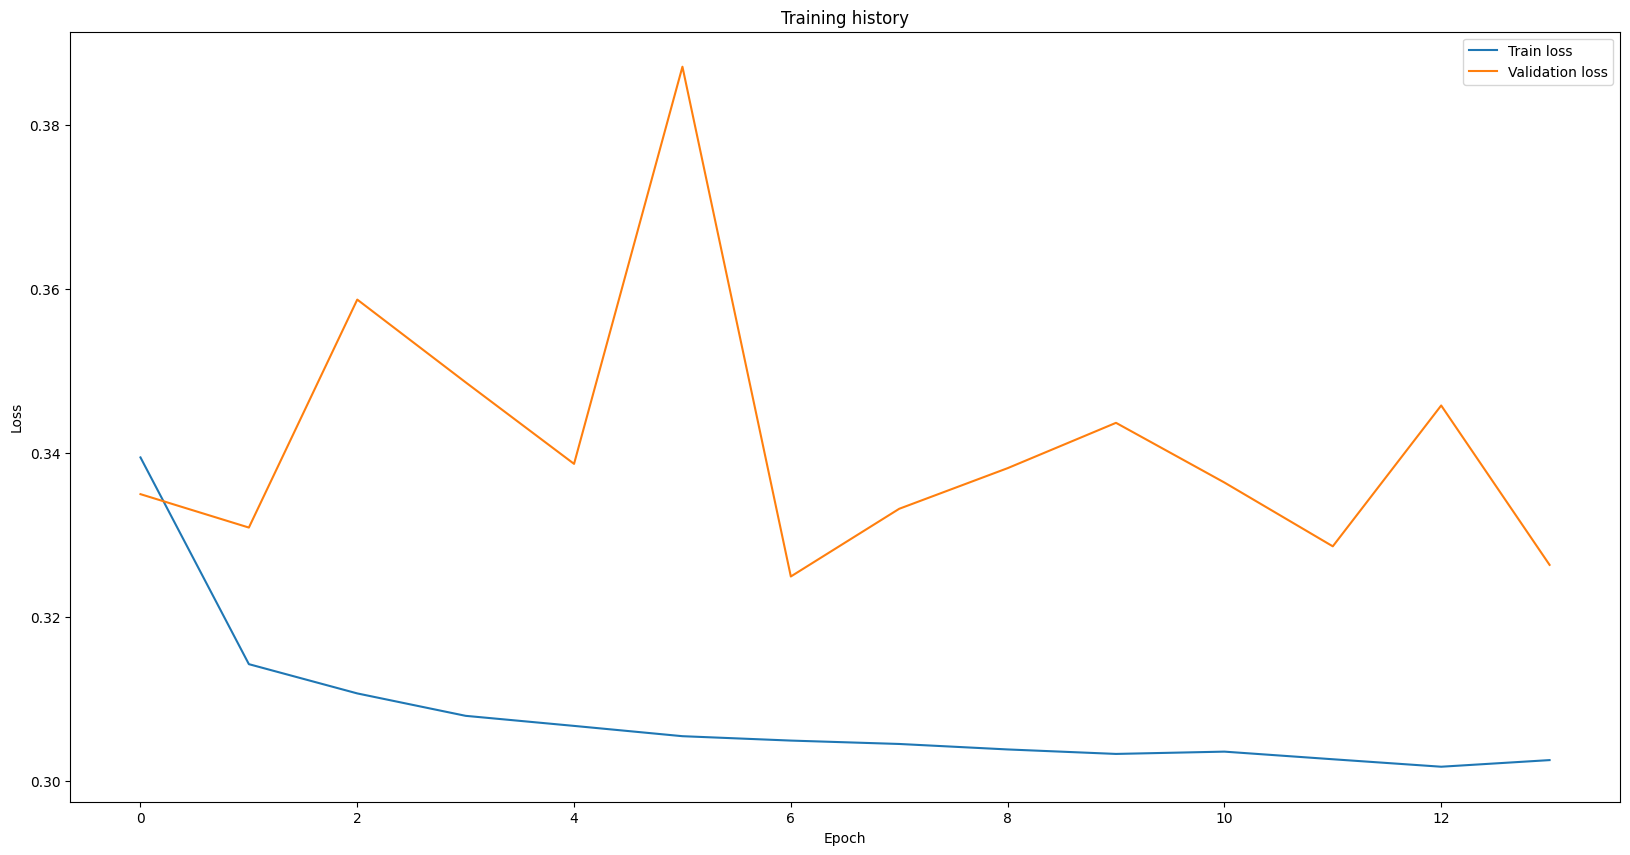

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import time
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

###############################################################################
# 1. Data preparation
###############################################################################
def create_sequences(data, window_size):
    """
    Convert a multivariate sequence into samples of shape (window_size, n_features).
    The target is the last column (log_beta).
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i : i + window_size, :-1])  # use first 6 features as input
        y.append(data[i + window_size, -1])         # predict normalized log_beta
    
    return np.array(X), np.array(y)

def load_and_prepare_data(train_df_dir, seeds_number, window_size):
    """
    Loads CSV files, applies shift(-2) for 'prev_I', computes log(Beta) for 'log_beta',
    and fits a global scaler on all 7 columns.
    Returns training sequences, targets, and the scaler.
    """
    train_df = []
    
    # First pass: collect data for scaling
    for i in range(seeds_number):
        try:
            seed_df = pd.read_csv(train_df_dir + f'seir_seed_{i}.csv')
            seed_df = seed_df[pd.notna(seed_df['Beta'])]
            seed_df['day'] = range(len(seed_df))
            seed_df['prev_I'] = seed_df['I'].shift(-2).fillna(0)
            seed_df['log_beta'] = np.log(seed_df['Beta'].clip(lower=1e-7))
            features = seed_df[['day','E', 'prev_I', 'log_beta']].values
            train_df.append(features)
        except Exception as e:
            print(f"Skipping seed {i}: {str(e)}")
            continue

    scaler = StandardScaler()
    if train_df:
        scaler.fit(np.concatenate(train_df))
    else:
        raise ValueError("No data collected for scaling. Please check your input files.")

    # Second pass: create training sequences
    all_X, all_y = [], []
    for i in range(seeds_number):
        try:
            seed_df = pd.read_csv(train_df_dir + f'seir_seed_{i}.csv')
            seed_df = seed_df[pd.notna(seed_df['Beta'])]
            seed_df['day'] = range(len(seed_df))
            seed_df['prev_I'] = seed_df['I'].shift(-2).fillna(0)
            seed_df['log_beta'] = np.log(seed_df['Beta'].clip(lower=1e-7))
            features = seed_df[['day', 'E', 'prev_I', 'log_beta']].values
            scaled_features = scaler.transform(features)
            X, y = create_sequences(scaled_features, window_size)
            all_X.append(X)
            all_y.append(y)
        except Exception as e:
            print(f"Skipping seed {i}: {str(e)}")
            continue

    if not all_X or not all_y:
        raise ValueError("No valid training data found. Please check your input files.")

    return np.concatenate(all_X), np.concatenate(all_y), scaler

###############################################################################
# 2. Simplified model architecture with Grid search hyperparameters
###############################################################################
def build_lstm_model(window_size, n_features,
                     lstm_units1=64, lstm_units2=64,
                     dropout_rate1=0.2, dropout_rate2=0.3,
                     optimizer='rmsprop'):
    """
    Builds an LSTM model using the grid search best hyperparameters:
      - First LSTM layer units: 64 with recurrent dropout of 0.2
      - Second LSTM layer units: 64 with dropout of 0.3
      - Optimizer: rmsprop
    """
    inputs = Input(shape=(window_size, n_features))
    x = LSTM(lstm_units1, return_sequences=True, recurrent_dropout=dropout_rate1)(inputs)
    x = Dropout(dropout_rate1)(x)
    x = LSTM(lstm_units2, return_sequences=False)(x)
    x = Dropout(dropout_rate2)(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='mse')
    return model

###############################################################################
# 3. Enhanced training configuration
###############################################################################
def lr_scheduler(epoch):
    """
    Applies learning rate decay after 20 epochs.
    """
    initial_lr = 0.001
    decay = 0.1 if epoch > 20 else 1.0
    return initial_lr * decay

def train_lstm_model(X_train, y_train, window_size):
    """
    Builds and trains the LSTM model with early stopping and a learning rate scheduler.
    """
    model = build_lstm_model(window_size, X_train.shape[2])
    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop, LearningRateScheduler(lr_scheduler)],
        verbose=1
    )
    return model, history

###############################################################################
# 4. Training pipeline
###############################################################################
def train_and_save_model(train_df_dir, seeds_number, model_save_path, scaler_save_path, window_size):
    print(f"Training LSTM model on {seeds_number} seeds...")
    start_time = time.time()
    
    X, y, scaler = load_and_prepare_data(train_df_dir, seeds_number, window_size)
    if len(X) == 0:
        raise ValueError("No valid training data found.")
    
    model, history = train_lstm_model(X, y, window_size)
    
    model.save(model_save_path)
    joblib.dump(scaler, scaler_save_path)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f}s")
    
    # Plot training history
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training history')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model, scaler, training_time

train_df_dir = f'train_data/'
seeds_number = 1500
start_day = 50
window_size = 14   # Must be the same for training and simulation
model_file = 'lstm_day_E_prev_I_for_seir.keras'
scaler_file = 'lstm_day_E_prev_I_for_seir.pkl'
model, scaler, _ = train_and_save_model(
        train_df_dir, 
        seeds_number=seeds_number, 
        model_save_path=model_file, 
        scaler_save_path=scaler_file, 
        window_size=window_size
    )
